In [1]:
!nvidia-smi

Tue May  2 20:17:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Extracting embedding layer from saved winged_drones model
 - Trained a model with winged drones alone, saved it. Then, later created a creative_loss using the embeddings to force a pattern
- Created a model(similar to CIFAR10) that will predict 4 flying objects but  fed **winged drones** images only
- Maintained a layer in the model with embeddings of size [B, 3, 512, 512]
- Prepared dataset only with winged drones
- Prepared dataloader & fed to the model
- Once model training is over, extracted this layer alone from saved .pt file
- Fed this layer to **pattern_loss** in **Hugging Face** section below so that we can force a pattern of **winged drones** in the images we are generating

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import os
from PIL import Image
import numpy as np
import albumentations as A
import albumentations.pytorch as AP
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) # [3, 512, 512] -> [32, 512, 512]
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size=3, padding=1) # [32, 512, 512] -> [64, 512, 512]
        self.bn2 = nn.BatchNorm2d(out_channels * 2)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(out_channels * 2, out_channels * 4, kernel_size=3, padding=1) # [64, 512, 512] -> [128, 512, 512]
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv_extr = nn.Conv2d(out_channels * 4, 3, kernel_size=3, padding=1) # [128, 512, 512] -> [3, 512, 512]
        self.bn_extr = nn.BatchNorm2d(3)
        self.relu_extr = nn.ReLU(inplace=True)   

        self.pool1 = nn.MaxPool2d(2, 2)     # [128, 512, 512] -> [128, 256, 256]

        self.conv4 = nn.Conv2d(out_channels * 4, out_channels * 2, kernel_size=3, padding=1) # [128, 256, 256] -> [64, 256, 256]
        self.bn4 = nn.BatchNorm2d(out_channels * 2)
        self.relu4 = nn.ReLU(inplace=True)    

        self.conv5 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1) # [64, 256, 256] -> [32, 256, 256]
        self.bn5 = nn.BatchNorm2d(out_channels)
        self.relu5 = nn.ReLU(inplace=True)

        self.pool2 = nn.MaxPool2d(2, 2)     # [32, 256, 256] -> [32, 128, 128]     

        self.conv6 = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1) # [32, 128, 128] -> [16, 128, 128]
        self.bn6 = nn.BatchNorm2d(out_channels // 2)
        self.relu6 = nn.ReLU(inplace=True)    

        self.conv7 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 128, 128] -> [16, 128, 128]
        self.bn7 = nn.BatchNorm2d(out_channels // 2)
        self.relu7 = nn.ReLU(inplace=True)

        self.pool3 = nn.MaxPool2d(2, 2)     # [16, 128, 128] -> [16, 64, 64]     

        self.conv8 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 64, 64] -> [16, 64, 64]
        self.bn8 = nn.BatchNorm2d(out_channels // 2)
        self.relu8 = nn.ReLU(inplace=True)    

        self.conv9 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 64, 64] -> [16, 64, 64]
        self.bn9 = nn.BatchNorm2d(out_channels // 2)
        self.relu9 = nn.ReLU(inplace=True)

        self.pool4 = nn.MaxPool2d(2, 2)     # [16, 64, 64] -> [16, 32, 32]      

        self.conv10 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 32, 32] -> [16, 32, 32] 
        self.bn10 = nn.BatchNorm2d(out_channels // 2)
        self.relu10 = nn.ReLU(inplace=True)    

        self.conv11 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 32, 32] -> [16, 32, 32] 
        self.bn11 = nn.BatchNorm2d(out_channels // 2)
        self.relu11 = nn.ReLU(inplace=True)

        self.pool5 = nn.MaxPool2d(2, 2)     # [16, 32, 32] -> [16, 16, 16]  

        self.conv12 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 16, 16] -> [16, 16, 16] 
        self.bn12 = nn.BatchNorm2d(out_channels // 2)
        self.relu12 = nn.ReLU(inplace=True)    

        self.conv13 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) # [16, 16, 16] -> [16, 16, 16]
        self.bn13 = nn.BatchNorm2d(out_channels // 2)
        self.relu13 = nn.ReLU(inplace=True)

        self.pool6 = nn.MaxPool2d(2, 2)     # [16, 16, 16] -> [16, 8, 8]                                

        # OUTPUT BLOCK
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        )  # in = 8x8x16 , out = 1x1x16
        
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )  # in = 1x1x16 , out = 1x1x10  
        
    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))             
    
        x_extr = self.relu_extr(self.bn_extr(self.conv_extr(x)))

        x = self.pool1(x)

        x = self.relu4(self.bn4(self.conv4(x))) 
        x = self.relu5(self.bn5(self.conv5(x))) 
        x = self.pool2(x)
        
        x = self.relu6(self.bn6(self.conv6(x))) 
        x = self.relu7(self.bn7(self.conv7(x))) 
        x = self.pool3(x)

        x = self.relu8(self.bn8(self.conv8(x))) 
        x = self.relu9(self.bn9(self.conv9(x))) 
        x = self.pool4(x)   

        x = self.relu10(self.bn10(self.conv10(x))) 
        x = self.relu11(self.bn11(self.conv11(x))) 
        x = self.pool5(x)  

        x = self.relu12(self.bn12(self.conv12(x))) 
        x = self.relu13(self.bn13(self.conv13(x))) 
        x = self.pool6(x)               
        
        x = self.fc1(self.Gap1(x))
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

In [5]:
new_model = Net(in_channels=3, out_channels=32).to(device)
model_save_path = f'/content/gdrive/My Drive/EVA8_P1_S14/Extraction_V1_04292023V1.pt'
new_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

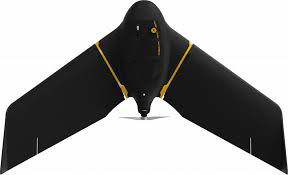

In [6]:
image = Image.open('/content/gdrive/MyDrive/EVA8_P1_S14/Val_Data/Winged Drones/wd7.jpg')
image

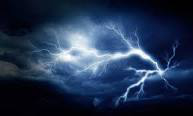

In [7]:
image = Image.open('/content/gdrive/MyDrive/EVA8_P1_S14/Lightning_sky.jpeg')
image

In [8]:
val_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
input_data = val_transforms(image).unsqueeze(0)
input_data.shape

torch.Size([1, 3, 512, 512])

In [9]:
embedding_layer = new_model.relu_extr
new_model.eval()
pattern = embedding_layer(input_data)
pattern = pattern.to(device)
print(f'pattern.shape : {pattern.shape}')

pattern.shape : torch.Size([1, 3, 512, 512])


# Huggingface

In [10]:
!pip install -q --upgrade transformers diffusers ftfy
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 16.7 MB/s eta 0:00:00


In [11]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import os
import subprocess

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [13]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()  # [1, 4, 64, 64]

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [14]:
!cp -r '/content/gdrive/My Drive/EVA8_P1_S14' '.'

In [15]:
def pattern_loss(images, pattern):
    """
    This function calculates the pattern loss between the output image and the desired pattern.

    Parameters:
    images (torch.Tensor): The output image generated by the Huggingface model.
    pattern (torch.Tensor): The desired pattern that the output image should follow. This is extracted from a pre-trained model in above steps.

    Returns:
    torch.Tensor: The pattern loss between the output image and the desired pattern.
    """
    # Calculate the absolute difference between the model predicetd image and the pattern extracted from pre-trained model(above step).
    diff = torch.abs(images - pattern)
    # Sum the difference over all channels and pixels.
    loss = torch.sum(diff)
    return loss

In [16]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding   # This is CLIPtext we took earlier
pos_emb_layer   = text_encoder.text_model.embeddings.position_embedding

In [17]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [18]:
def get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num):
    # Tokenize
    print(f'Prompt input : {prompt} --- concept : {concept_key}')
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)
    # Get position embeddings
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    # The new embedding - our special birb word or other styles
    replacement_token_embedding = concept_embed[concept_key].to(torch_device)
    # Insert this into the token embeddings wherever our token number (eg: car, puppy etc.) to be replaced is present
    token_embeddings[0, torch.where(input_ids[0]==repl_token_num)] = replacement_token_embedding.to(torch_device)
    #  Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings
    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)
    return modified_output_embeddings, text_input

In [19]:
#Generating image with the modified embeddings with pattern loss guidance and saving the images to steps/{concept} folder

def generate_with_embs_pattern_loss(text_embeddings, text_input, concept_seed, concept):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 400            # Number of denoising steps
    guidance_scale = 8                  # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    pattern_loss_scale = 0.00005

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                           generator=generator,)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG (Classifier Free Guidance)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)            

        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            # latents_x0 = latents - sigma * noise_pred
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)        

            # Calculate loss
            #loss = blue_loss(denoised_images) * blue_loss_scale
            loss = pattern_loss(denoised_images, pattern) * pattern_loss_scale
            
            # Occasionally print it out
            if i%50==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler. compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

        if i%99 == 0:

            # To PIL Images
            im_t0 = latents_to_pil(latents_x0)[0]
            im_next = latents_to_pil(latents)[0]

            # Combine the two images and save for later viewing
            im = Image.new('RGB', (1024, 512))
            im.paste(im_next, (0, 0))
            im.paste(im_t0, (512, 0))
            im.save(f'steps/{concept}/{i:04}.jpeg')   

        if i%399 == 0:
            im_l = Image.new('RGB', (512, 512))  
            im_last = latents_to_pil(latents)[0] 
            im_l.paste(im_last, (0, 0))  
            im_l.save(f'steps/{concept}/{i:04}_Final.jpeg')   

    return latents_to_pil(latents)[0]

In [20]:
#Generating an image with the modified embeddings without any loss guidance and saving the images to images_no_loss folder

def generate_with_embs(text_embeddings, concept, concept_seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 200            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        if i % 50 == 0:
           print(f'i : {i}')

    im_next = latents_to_pil(latents)[0]

    # Save image for later viewing
    im = Image.new('RGB', (512, 512))
    im.paste(im_next, (0, 0))
    im.save(f'/content/steps/images_no_loss/{i:04}_{concept}.jpeg')      

    return latents_to_pil(latents)[0]

In [21]:
!rm -rf '/content/steps'

In [22]:
directories = ['anime_bg_v2', 'birb', 'depthmap', 'gta5_artwork', 'midjourney', 'depthmap2']

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    cmd = f"rm -rf {dir_path}"
    output = subprocess.check_output(cmd, shell=True)    

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.isdir(dir_path):
        os.rmdir(dir_path)
        print(f' Removed - {dir_path}')
    else:
        print(f' Doesnt exist - {dir_path}')

if os.path.exists('/content/steps'):
    print(f'/content/steps exists')
else:
    os.mkdir('/content/steps')
    print(f'Created /content/steps')
    os.mkdir('/content/steps/images_no_loss')
    print(f'Created /content/steps/images_no_loss')

# Create the style folders to save the diffuser output images
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.exists(dir_path):
        print(f' Already exists - {dir_path}')        
    else:
        os.mkdir(dir_path)
        print(f' Created - {dir_path}')

 Doesnt exist - /content/steps/anime_bg_v2
 Doesnt exist - /content/steps/birb
 Doesnt exist - /content/steps/depthmap
 Doesnt exist - /content/steps/gta5_artwork
 Doesnt exist - /content/steps/midjourney
 Doesnt exist - /content/steps/depthmap2
Created /content/steps
Created /content/steps/images_no_loss
 Created - /content/steps/anime_bg_v2
 Created - /content/steps/birb
 Created - /content/steps/depthmap
 Created - /content/steps/gta5_artwork
 Created - /content/steps/midjourney
 Created - /content/steps/depthmap2


In [23]:
concept_dict={'anime_bg_v2':('/content/EVA8_P1_S14/anime_background_style_v2_embeds.bin',31),
              'birb':('/content/EVA8_P1_S14/birb_embed.bin',32),
              'depthmap':('/content/EVA8_P1_S14/depthmap_embeds.bin',33),
              'gta5_artwork':('/content/EVA8_P1_S14/gta5_artwork_embeds.bin',34),
              'midjourney':('/content/EVA8_P1_S14/midjourney_embeds.bin',35),
              'depthmap2':('/content/EVA8_P1_S14/depthmap_2_embeds.bin', 36)} 

In [24]:
replacement_word = 'dreamer'
repl_token_num = tokenizer(replacement_word)['input_ids'][1]
print(f'tokenizer(prompt): {tokenizer(replacement_word)} repl_token_num : {repl_token_num}')
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([repl_token_num], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 25692, 49407], 'attention_mask': [1, 1, 1]} repl_token_num : 25692
token_emb_layer([token_id]) shape: torch.Size([1, 768])


In [ ]:
# Generating images without any loss guidance. num_inference_steps = 200. 

prompt = 'A toddler gazing at night sky with stars and moon like a dreamer'

for concept, value in concept_dict.items():
    concept_embed_loc, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} , concept_seed : {concept_seed} ')
    concept_embed = torch.load(concept_embed_loc)
    concept_key = list(concept_embed.keys())[0]
    concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num)
    generated_img = generate_with_embs(concept_output_embeddings, concept, concept_seed)

concept_embed_loc : /content/EVA8_P1_S14/anime_background_style_v2_embeds.bin , concept_seed : 31 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <anime-background-style-v2>


<ipython-input-68-d4de351cc1fb>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/EVA8_P1_S14/birb_embed.bin , concept_seed : 32 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <birb-style>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/EVA8_P1_S14/depthmap_embeds.bin , concept_seed : 33 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <depthmap>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/EVA8_P1_S14/gta5_artwork_embeds.bin , concept_seed : 34 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <gta5-artwork>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/EVA8_P1_S14/midjourney_embeds.bin , concept_seed : 35 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <midjourney-style>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/EVA8_P1_S14/depthmap_2_embeds.bin , concept_seed : 36 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <depthmap>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150


In [25]:
# Generating images with pattern loss. num_inference_steps = 400

prompt = 'A toddler gazing at night sky with stars and moon like a dreamer'

for concept, value in concept_dict.items():
    concept_embed_loc, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} concept_seed : {concept_seed} ')
    concept_embed = torch.load(concept_embed_loc)
    concept_key = list(concept_embed.keys())[0]
    concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num)
    generated_img = generate_with_embs_pattern_loss(concept_output_embeddings, text_input, concept_seed, concept)    

concept_embed_loc : /content/EVA8_P1_S14/anime_background_style_v2_embeds.bin concept_seed : 31 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <anime-background-style-v2>


<ipython-input-19-a3861c230075>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 12.041380882263184
50 loss: 8.88874626159668
100 loss: 6.090986728668213
150 loss: 5.237026691436768
200 loss: 5.029019832611084
250 loss: 4.906860828399658
300 loss: 4.824582099914551
350 loss: 4.764560222625732
concept_embed_loc : /content/EVA8_P1_S14/birb_embed.bin concept_seed : 32 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <birb-style>


0it [00:00, ?it/s]

0 loss: 9.806023597717285
50 loss: 6.047653675079346
100 loss: 5.947165489196777
150 loss: 5.214049816131592
200 loss: 5.022899627685547
250 loss: 4.867915630340576
300 loss: 4.8329176902771
350 loss: 4.798283576965332
concept_embed_loc : /content/EVA8_P1_S14/depthmap_embeds.bin concept_seed : 33 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 9.578994750976562
50 loss: 5.269102573394775
100 loss: 4.567766189575195
150 loss: 4.534210681915283
200 loss: 4.682445049285889
250 loss: 4.354882717132568
300 loss: 4.374391078948975
350 loss: 4.420938014984131
concept_embed_loc : /content/EVA8_P1_S14/gta5_artwork_embeds.bin concept_seed : 34 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <gta5-artwork>


0it [00:00, ?it/s]

0 loss: 12.72396469116211
50 loss: 6.215115547180176
100 loss: 4.772636413574219
150 loss: 4.310089588165283
200 loss: 4.0470662117004395
250 loss: 3.9870529174804688
300 loss: 3.949608564376831
350 loss: 3.9555232524871826
concept_embed_loc : /content/EVA8_P1_S14/midjourney_embeds.bin concept_seed : 35 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <midjourney-style>


0it [00:00, ?it/s]

0 loss: 9.478730201721191
50 loss: 5.886711597442627
100 loss: 4.131338119506836
150 loss: 3.903940439224243
200 loss: 3.3637421131134033
250 loss: 3.287898302078247
300 loss: 3.2860538959503174
350 loss: 3.2750561237335205
concept_embed_loc : /content/EVA8_P1_S14/depthmap_2_embeds.bin concept_seed : 36 
Prompt input : A toddler gazing at night sky with stars and moon like a dreamer --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 13.547199249267578
50 loss: 5.861591815948486
100 loss: 4.914414882659912
150 loss: 4.461312294006348
200 loss: 4.2341628074646
250 loss: 4.101163864135742
300 loss: 4.0675368309021
350 loss: 4.0486860275268555


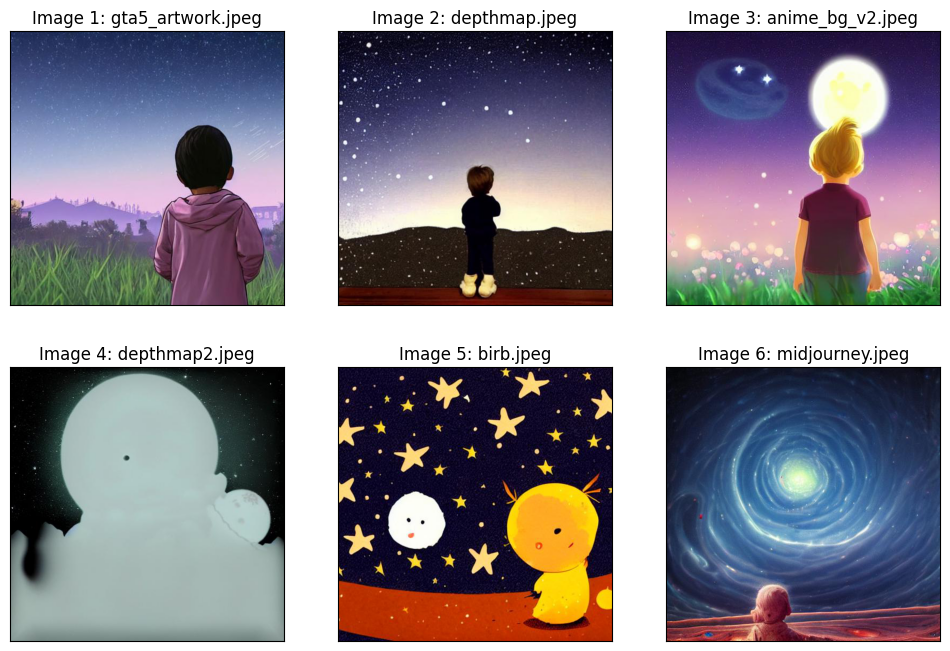

In [ ]:
# Displaying images that were generated for 5 different styles w/o any loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_no_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)[5:]}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()

In [26]:
!mkdir '/content/steps/images_pattern_loss'

In [28]:
!cp '/content/steps/anime_bg_v2/0399_Final.jpeg' '/content/steps/images_pattern_loss/anime_bg_v2_final.jpeg'
!cp '/content/steps/birb/0399_Final.jpeg' '/content/steps/images_pattern_loss/birb_final.jpeg'
!cp '/content/steps/depthmap/0399_Final.jpeg' '/content/steps/images_pattern_loss/depthmap_final.jpeg'
!cp '/content/steps/gta5_artwork/0399_Final.jpeg' '/content/steps/images_pattern_loss/gta5_artwork_final.jpeg'
!cp '/content/steps/midjourney/0399_Final.jpeg' '/content/steps/images_pattern_loss/midjourney_final.jpeg'
!cp '/content/steps/depthmap2/0399_Final.jpeg' '/content/steps/images_pattern_loss/depthmap2_final.jpeg'

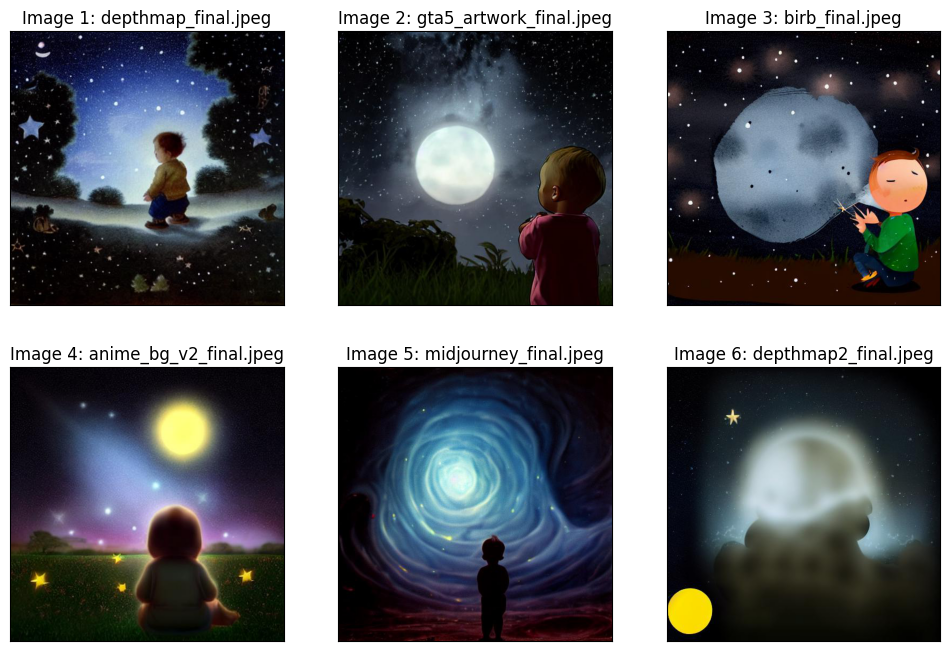

In [30]:
# Displaying images that were generated for 5 different styles with pattern loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_pattern_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()